# HOUSEHOLD CONSUMPTIONS

This notebook contains <br>
[0. Import libraries and data](#0.-Import-libraries-and-data) <br>
[1. Building the DataFrame](#1.-Building-the-DataFrame) <br>
[2. Energy prices](#2.-Energy-Prices)<br>
[3. Recommendations](#3.-Recommendations)

## 0. Import libraries and data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# CSV file containing the household data
#url = "https://data.open-power-system-data.org/household_data/latest/household_data_60min_singleindex.csv"
url= "household_data_60min_singleindex.csv"
df = pd.read_csv(url, sep=",")

As the source of the data stated, the numbers are cumulative power / generation over time.

## 1. Building the DataFrame 

### Datetime information and types
First the date type is going to be convert and some information extracted in new columns to work with it

In [3]:
df['Datetime'] = df[df.columns[0]].apply(pd.to_datetime)
df['Year'] = pd.DatetimeIndex(df['Datetime']).year
df['Date'] = pd.DatetimeIndex(df['Datetime']).date
df['Hour'] = pd.DatetimeIndex(df['Datetime']).hour
df.dtypes[len(df.dtypes)-4:len(df.dtypes)-1]

Datetime    datetime64[ns]
Year                 int64
Date                object
dtype: object

In [4]:
#Check all the types
df.dtypes.value_counts()

float64           70
object             4
int64              2
datetime64[ns]     1
dtype: int64

In [5]:
df.dtypes[df.dtypes.values == object]

utc_timestamp          object
cet_cest_timestamp     object
interpolated_values    object
Date                   object
dtype: object

In [6]:
df['Date'] = df['Date'].apply(pd.to_datetime)
df.dtypes.value_counts()

float64           70
object             3
int64              2
datetime64[ns]     2
dtype: int64

All the information that is going to be use have the proper time since the object columns are not neccesary anymore

### Selecting specific data
#### Time period


In [7]:
first_day = df['Date'].iloc[0]
last_day = df['Date'].iloc[-1]
print("The dataframe contains information from", first_day, "to", last_day)

The dataframe contains information from 2015-04-15 00:00:00 to 2017-02-09 00:00:00


To be able to study a whole natural year only the data from year 2016 is going to be studied

In [8]:
df_2016 = df[df['Year']==2016]
df_2016.head(2)

,utc_timestamp,cet_cest_timestamp,DE_KN_industrial1_grid_import,DE_KN_industrial1_pv_1,DE_KN_industrial1_pv_2,DE_KN_industrial2_grid_import,DE_KN_industrial2_pv_1,DE_KN_industrial2_storage_charge,DE_KN_industrial2_storage_decharge,DE_KN_industrial3_area_offices,...,DE_KN_residential6_freezer,DE_KN_residential6_grid_export,DE_KN_residential6_grid_import,DE_KN_residential6_pv,DE_KN_residential6_washing_machine,interpolated_values,Datetime,Year,Date,Hour
6253,2016-01-01T00:00:00Z,2016-01-01T01:00:00+0100,24436.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-240.999,NaN,NaN,NaN,6.932,DE_KN_residential5_dishwasher,2016-01-01 00:00:00,2016,2016-01-01,0
6254,2016-01-01T01:00:00Z,2016-01-01T02:00:00+0100,24448.254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-240.985,NaN,NaN,NaN,6.932,DE_KN_residential5_dishwasher,2016-01-01 01:00:00,2016,2016-01-01,1


#### Dataframe by houses
As the dataframe contains the data for 11 households in southern Germany it is neccesary to divide it to have individual dataframes with the same structure for each house.
To do it a new dataframe with columns names is built

In [9]:
col_names= pd.DataFrame(list(df),columns=['Col_name'])
col_names.head()

,Col_name
0,utc_timestamp
1,cet_cest_timestamp
2,DE_KN_industrial1_grid_import
3,DE_KN_industrial1_pv_1
4,DE_KN_industrial1_pv_2


The structure of the names of the columns is several concepts separated by _ symbol. The house type and number are in the 3rd field and the following concepts describe the type of comsuption, appliances or charges.<br><br>
The next block contains the definition of functions to divide the column names and extract the necessary information.

In [10]:
def gethousenumber(col_name):
    fields = str(col_name).split("_")
    house_field = 2
    house_num = fields[house_field][-1] if len(fields)>house_field else 0
    return int(house_num) if str(house_num).isdigit() else 0

def getconcept(col_name):
    fields = str(col_name).split("_")
    fields_num = len(fields)
    fixed_fields = 3
    field = list(range(fixed_fields,fields_num))
    return str(''.join([fields[num] for num in field]))

def residential(col_name):
    fields = str(col_name).split("_")
    house_field = 2
    house_type = fields[house_field][:-1] if len(fields)>house_field else 0
    return int(house_type == "residential")

With the functions new columns are created to contain the information about the house number, the consumption concept and whether is residential.

In [11]:
col_names['House_num'] = col_names['Col_name'].apply(gethousenumber)
col_names['Concept'] = col_names['Col_name'].apply(getconcept)
col_names['Residential'] = col_names['Col_name'].apply(residential)
col_names.sample(5)

,Col_name,House_num,Concept,Residential
67,DE_KN_residential6_freezer,6,freezer,1
36,DE_KN_residential1_pv,1,pv,1
50,DE_KN_residential3_refrigerator,3,refrigerator,1
52,DE_KN_residential4_dishwasher,4,dishwasher,1
64,DE_KN_residential5_washing_machine,5,washingmachine,1


In [12]:
col_names.dtypes

Col_name       object
House_num       int64
Concept        object
Residential     int64
dtype: object

It is neccesary to define a function to obtain the list of columns depending on the number of the house. With that list the dataframe containing all the data can be cutted into smaller ones, one for each house under study. <br> <br>
For the project only the residential households are going to be studied since the purpose of the project is to obtain recommendations for electrical household appliances. That's the reason residential is set True in the next function.

In [13]:
def df_byhouse(extraction_df, house_num):
    residential = True
    condition1 = col_names['Residential']== int(residential)
    condition2 = col_names['House_num']== house_num
    df_house = col_names[condition1 & condition2]
    #lists with the columns name and the equivalent name with only the concept
    col_list = list(df_house['Col_name'])
    col_list_concepts = list(df_house['Concept'])
    col_time = ['Datetime','Date','Year','Hour']
    col_list = col_time + col_list
    col_list_concepts = col_time + col_list_concepts
    #dataframe with only the columns from the input house
    df_byhouse = extraction_df[col_list]
    df_byhouse.columns = col_list_concepts
    return df_byhouse

The function takes the number of the house and the dataframe from which the data wants to be extracted. It brings back a dataframe containing only the columns from the house which number is given as input. Also the columns are rename to show only the concept since now there is no ambiguity.

In [14]:
df_residential2 = df_byhouse(df_2016,2)
df_residential2.head()

,Datetime,Date,Year,Hour,circulationpump,dishwasher,freezer,gridimport,heating,washingmachine
6253,2016-01-01 00:00:00,2016-01-01,2016,0,236.750,NaN,NaN,1495.785,NaN,NaN
6254,2016-01-01 01:00:00,2016-01-01,2016,1,236.803,NaN,NaN,1495.945,NaN,NaN
6255,2016-01-01 02:00:00,2016-01-01,2016,2,236.855,NaN,NaN,1496.145,NaN,NaN
6256,2016-01-01 03:00:00,2016-01-01,2016,3,236.919,NaN,NaN,1496.260,NaN,NaN
6257,2016-01-01 04:00:00,2016-01-01,2016,4,236.998,NaN,NaN,1496.410,NaN,NaN


This function will be use later on to treat and save the data but first the values need to be cleaned.

### Handle the missing values
The first step is to assess how many missing values are in the dataframe


In [15]:
def nan_in_df(df):
    nan_count = len(df) - df.count()
    return nan_count

In [16]:
nan_in_df(df_2016).sort_values()[:10]

utc_timestamp                          0
Year                                   0
Datetime                               0
Date                                   0
Hour                                   0
cet_cest_timestamp                     0
DE_KN_residential4_refrigerator       68
DE_KN_residential4_dishwasher         71
DE_KN_residential4_washing_machine    71
DE_KN_residential4_heat_pump          71
dtype: int64

The house with the less NaN values is the number 4 so it is going to be inspect in detail. Also is important to remember that for the purpose of the project the data that needs to be taken special attention is the dishwasher and the washing machine values.

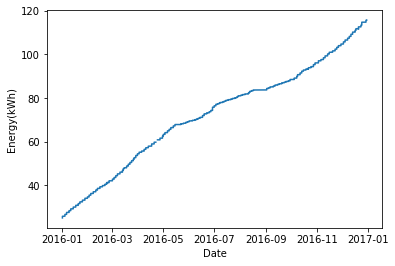

In [17]:
residential4= df_byhouse(df_2016,4)
plt.xlabel ('Date')
plt.ylabel ("Energy(kWh)")
plt.plot(residential4['Date'],residential4['dishwasher'])

In [18]:
#Function to filter to help explore specific date and concept
def filter_greaterdate(df,input_date,concept):
    filter_date = pd.to_datetime(input_date)
    col_list = list(df.columns[:3]) + [concept]
    return df[df['Date'] > filter_date][col_list]

In [19]:
filtered_r4 = filter_greaterdate(residential4, '31-12-2015', 'dishwasher')
gaps_r4 = filtered_r4[filtered_r4['dishwasher'].isnull()]

#Check which months have NaN values
months = gaps_r4['Date'].map(lambda x: x.month)
gaps_r4.groupby(months).count()

,Datetime,Date,Year,dishwasher
Date,,,,
2,2,2,2,0
4,54,54,54,0
10,12,12,12,0
12,3,3,3,0


There are 4 months with gaps and the greater is in April so that period is going to be study as example to check which method is better to use with the NaN values

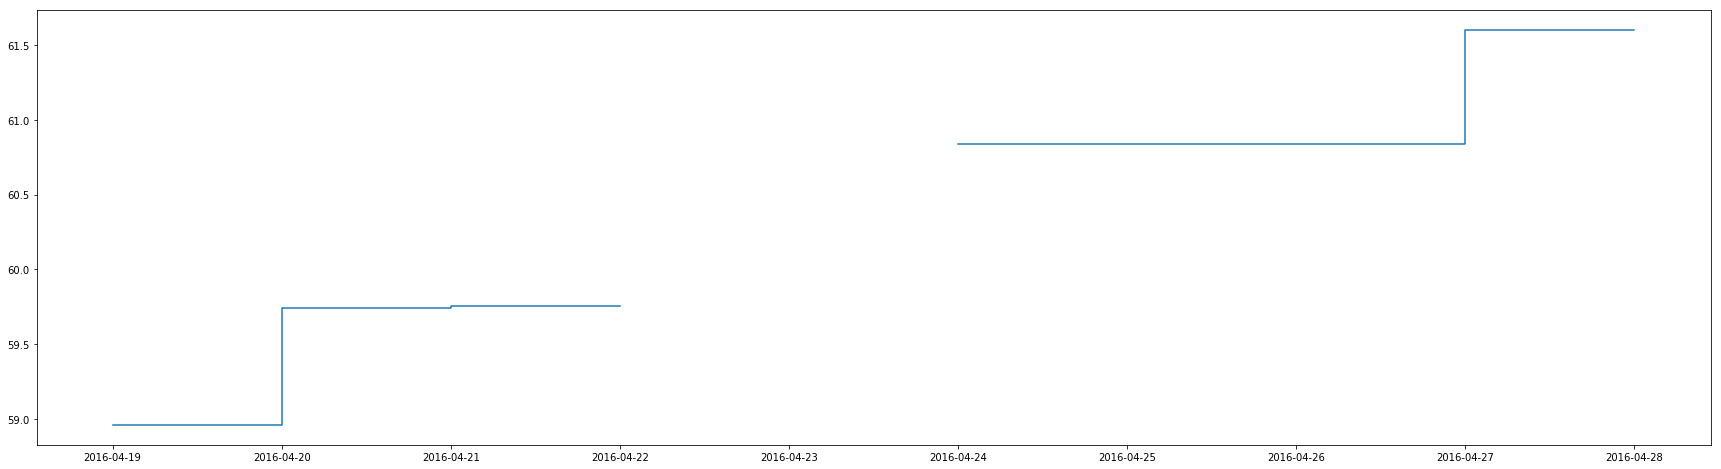

In [20]:
#Select x previous and x subsequent values to study the shape of the data
gaps_index = gaps_r4[months==4].index
num_values = 80
init_val = gaps_index[0]-num_values
end_val = gaps_index[len(gaps_index)-1]+num_values
april_gaps = filtered_r4.loc[init_val:end_val]

#Plot the data to visualize
plt.figure(figsize=(30,8))
plt.plot(april_gaps['Date'],april_gaps['dishwasher'])

Because there is no data in that periods it is assumed there is no consumption, therefore the cumulative is constant. The NaN are going to be substitute by the previous value, using the method *ffill* from the *fillna* function.

In [21]:
filtered_r4['dishwasher_clean'] = filtered_r4['dishwasher'].fillna(method='ffill')
filtered_r4.iloc[2701:2705]

,Datetime,Date,Year,dishwasher,dishwasher_clean
8954,2016-04-22 13:00:00,2016-04-22,2016,59.757,59.757
8955,2016-04-22 14:00:00,2016-04-22,2016,59.757,59.757
8956,2016-04-22 15:00:00,2016-04-22,2016,NaN,59.757
8957,2016-04-22 16:00:00,2016-04-22,2016,NaN,59.757


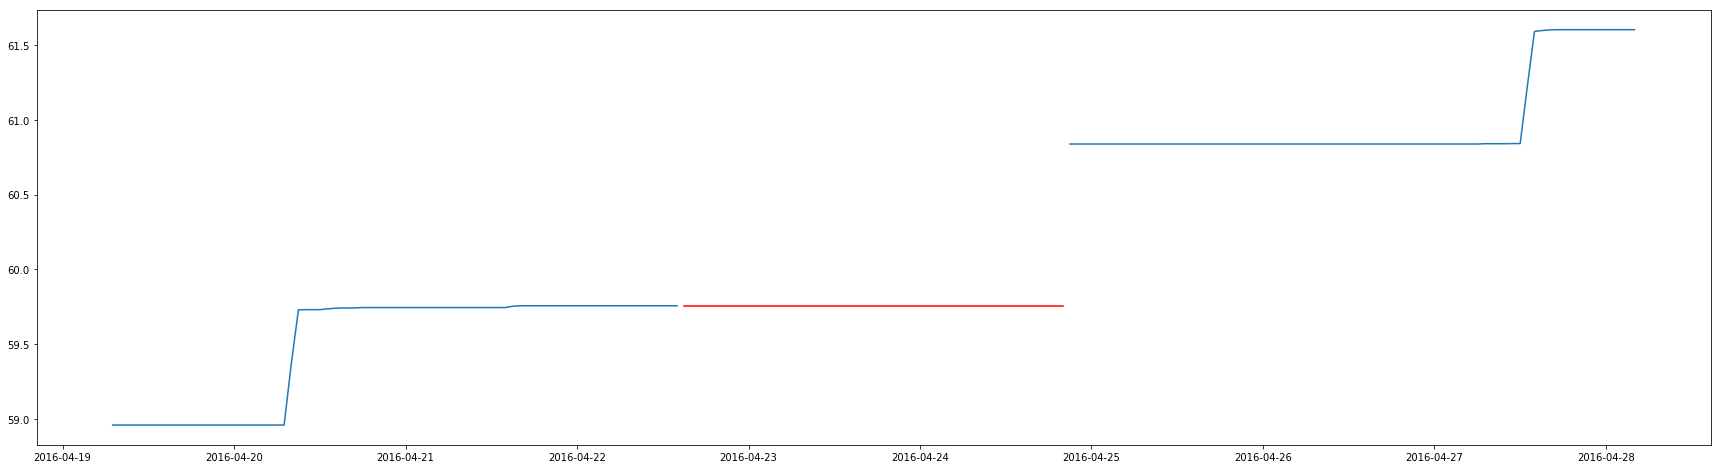

In [22]:
#Visualize the data after fillna
plt.figure(figsize=(30,8))
plt.plot(april_gaps['Datetime'],april_gaps['dishwasher'])
dates_nan = april_gaps[april_gaps['dishwasher'].isnull()]['Datetime'].values
y = filtered_r4[filtered_r4['Datetime'].isin(dates_nan)]['dishwasher_clean']
plt.plot(dates_nan,y, color='r')

Once the method makes sense for the data under study, it is going to be applied for the whole dataframe

In [23]:
df_2016 = df_2016.fillna(method='ffill')
df_2016.head(1)

,utc_timestamp,cet_cest_timestamp,DE_KN_industrial1_grid_import,DE_KN_industrial1_pv_1,DE_KN_industrial1_pv_2,DE_KN_industrial2_grid_import,DE_KN_industrial2_pv_1,DE_KN_industrial2_storage_charge,DE_KN_industrial2_storage_decharge,DE_KN_industrial3_area_offices,...,DE_KN_residential6_freezer,DE_KN_residential6_grid_export,DE_KN_residential6_grid_import,DE_KN_residential6_pv,DE_KN_residential6_washing_machine,interpolated_values,Datetime,Year,Date,Hour
6253,2016-01-01T00:00:00Z,2016-01-01T01:00:00+0100,24436.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-240.999,NaN,NaN,NaN,6.932,DE_KN_residential5_dishwasher,2016-01-01,2016,2016-01-01,0


This method is not valid for the columns that have no values at the begginning of the year. In that case we are going to assume that the first value of data is the valid one, so we apply the bfill method of the function.  

In [24]:
df_2016 = df_2016.fillna(method='bfill')
df_2016.head(1)

,utc_timestamp,cet_cest_timestamp,DE_KN_industrial1_grid_import,DE_KN_industrial1_pv_1,DE_KN_industrial1_pv_2,DE_KN_industrial2_grid_import,DE_KN_industrial2_pv_1,DE_KN_industrial2_storage_charge,DE_KN_industrial2_storage_decharge,DE_KN_industrial3_area_offices,...,DE_KN_residential6_freezer,DE_KN_residential6_grid_export,DE_KN_residential6_grid_import,DE_KN_residential6_pv,DE_KN_residential6_washing_machine,interpolated_values,Datetime,Year,Date,Hour
6253,2016-01-01T00:00:00Z,2016-01-01T01:00:00+0100,24436.75,412.9,3284.23,2.435,2269.545,0.0,0.0,3761.016,...,-240.999,0.4,1929.07,1361.605,6.932,DE_KN_residential5_dishwasher,2016-01-01,2016,2016-01-01,0


## 2. Energy Prices

To calculate the cost for the hourly energy consumption the prices information is neccesary. It is obtain from a csv generated from the jupyter notebook Prices_data. 

In [25]:
#Join with prices and calculate cost
df_prices = pd.read_csv('Prices.csv', sep=",")
df_prices = df_prices[['Datetime','Price']]
df_prices['Datetime'] = pd.to_datetime(df_prices['Datetime'], format='%Y.%m.%d %H:%M')
df_prices.dtypes

Datetime    datetime64[ns]
Price              float64
dtype: object

That hourly prices are not the final prices paid by the consumers at household level because taxes have to be taken into account. An assumption is going to be made to try to adjust the prices based in information from different sources (for detailed information see the readme file): the price will be increased by a 2 factor.



In [26]:
df_prices['Price']=df_prices['Price']*2
df_prices.head()

,Datetime,Price
0,2016-01-01 00:00:00,44.78
1,2016-01-01 01:00:00,41.18
2,2016-01-01 02:00:00,33.62
3,2016-01-01 03:00:00,34.82
4,2016-01-01 04:00:00,34.04


In [27]:
df_2016_prices = df_2016.merge(df_prices)

### Costs per appliance
The consumption is aggregated so to know the cost of each hour that the appliance had been working a new column is added with the difference. <br>
To have the data by house, the function df_byhouse is going to be used, but it is neccesary to add the price column.

In [28]:
def df_byhouse(extraction_df, house_num):
    residential = True
    condition1 = col_names['Residential']== int(residential)
    condition2 = col_names['House_num']== house_num
    df_house = col_names[condition1 & condition2]
    #lists with the columns name and the equivalent name with only the concept
    col_list = list(df_house['Col_name'])
    col_list_concepts = list(df_house['Concept'])
    col_common = ['Datetime','Date','Year','Hour','Price']
    col_list = col_common + col_list
    col_list_concepts = col_common + col_list_concepts
    #dataframe with only the columns from the input house
    df_byhouse = extraction_df[col_list]
    df_byhouse.columns = col_list_concepts
    return df_byhouse

In [29]:
#Obtain a list containing all the dataframes
list_df=list()
for i in list(range(1,7)):
    df=df_byhouse(df_2016_prices,i)
    list_df.append(df)

In [30]:
#Names for the dataframes generated for each house
residential=list(['residential']*6)
numbers =list(map(str,list(range(1,7))))
list_dfnames = list(map(str.__add__,residential,numbers))

In [31]:
list_dfclean = list()
conversionf = 1/1000  #the prices are in €/MWh and the consumption of the appliance in kWh
appliances = ['dishwasher','washingmachine']

for elem in list_df:
    for app in appliances:
        appliance_dif = app + '_dif'
        appliance_cost = app + '_cost'
        elem[appliance_dif]= abs(elem[app].diff(periods=-1))
        elem[appliance_cost] = elem['Price'] * elem[appliance_dif]* conversionf
    list_dfclean.append(elem)

C:\Users\AROA\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\AROA\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [32]:
list_dfclean[0]['dishwasher'].tail()

8779    232.665
8780    232.666
8781    232.666
8782    232.666
8783    232.666
Name: dishwasher, dtype: float64

Once the dataframes are generated they will be saved into csv files to be used for the Shiny App

In [33]:
#Save the files in the correct directory for shiny
from pathlib import Path

path = Path("~/Documents/MASTER/TFM/data/")
for i in list(range(0, len(list_dfclean))):
    name=list_dfnames[i] + '.csv'
    list_dfclean[i].to_csv(path / name)

In [34]:
list_dfclean[2].head()

,Datetime,Date,Year,Hour,Price,circulationpump,dishwasher,freezer,gridexport,gridimport,pv,refrigerator,washingmachine,dishwasher_dif,dishwasher_cost,washingmachine_dif,washingmachine_cost
0,2016-01-01 00:00:00,2016-01-01,2016,0,44.78,635.48,604.017,124.858,0.0,0.391,0.0,209.835,560.369,0.0,0.0,0.0,0.0
1,2016-01-01 01:00:00,2016-01-01,2016,1,41.18,635.48,604.017,124.858,0.0,0.391,0.0,209.835,560.369,0.0,0.0,0.0,0.0
2,2016-01-01 02:00:00,2016-01-01,2016,2,33.62,635.48,604.017,124.858,0.0,0.391,0.0,209.835,560.369,0.0,0.0,0.0,0.0
3,2016-01-01 03:00:00,2016-01-01,2016,3,34.82,635.48,604.017,124.858,0.0,0.391,0.0,209.835,560.369,0.0,0.0,0.0,0.0
4,2016-01-01 04:00:00,2016-01-01,2016,4,34.04,635.48,604.017,124.858,0.0,0.391,0.0,209.835,560.369,0.0,0.0,0.0,0.0


## 3. Recommendations

The recommendations are going to be based in the use pattern for the specific house in that year

In [35]:
#Definition of a function to study use patterns by hours
def use_pattern(df,appliance):
    filter_exp = df[appliance + '_dif'] != 0
    data = pd.DataFrame(df[filter_exp].groupby('Hour').count()['Date'])
    data.rename(columns={'Date' : 'Count'},inplace=True)
    return data

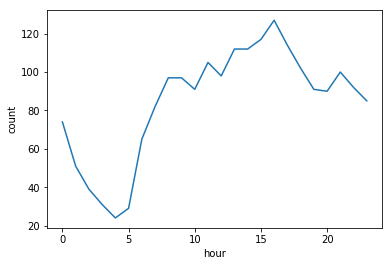

In [36]:
residential2 = list_dfclean[2]
data = use_pattern(residential2, 'washingmachine')
plt.xlabel ('hour')
plt.ylabel ('count')
plt.plot(data)

To be able to see the use pattern depending on the day the function use_pattern has to be changed a bit

In [37]:
def use_pattern2plt(df,appliance):
    #Create a column to know if it is a weekday(1), saturday(2) or sunday(3)
    df['Day_type'] = df['Datetime'].map(lambda x: 1 if x.dayofweek <= 4 else 2 if x.dayofweek == 5 else 3 )
    filter_exp = df[appliance + '_dif'] != 0
    data = df[filter_exp]
    plt.figure(figsize=(12,5))
    for i in list(range(1,4)):
        filtered_data = data[data['Day_type']==i].groupby(['Hour']).count()['Date']
        filtered_data.rename(columns={'Date' : 'Count'},inplace=True)
        plt.xlabel ('hour')
        plt.ylabel ('count')
        day_name = 'Weekday' if i==1 else'Saturday' if i==2 else'Sunday'
        plt.plot(filtered_data, label = day_name)
        plt.legend()
        

C:\Users\AROA\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


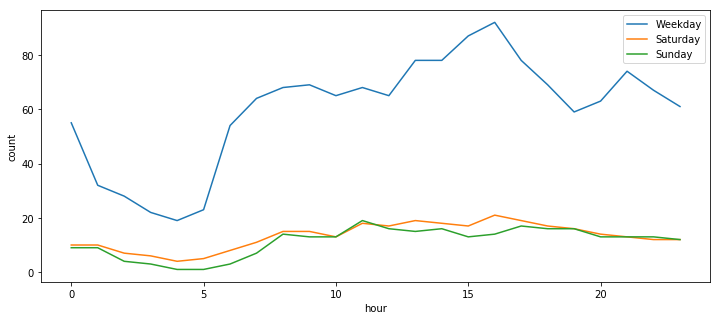

In [38]:
use_pattern2plt(residential2, 'washingmachine')

In [39]:
#Load the cluster_prices for each hour
from pathlib import Path

path = Path("~/Documents/MASTER/TFM/data/")
name = 'Cluster_prices.csv'

prices_cluster = pd.read_csv(path / name)
prices_cluster.head(6)

,Hour,Cluster_id,Price_weekday,Price_sat,Price_sun
0,0,0,22.245594,23.267736,17.756731
1,1,0,21.259004,22.121887,16.856538
2,2,0,21.253985,21.703774,16.447500
3,3,0,22.811762,21.910377,16.346923
4,4,2,27.572759,22.462264,16.354231
5,5,3,33.968161,23.646226,16.132500


For the recommendations the criteria is going to be used is a simple logic to try to make it easy for the user to implement it. If the hour before or after has a "better cluster" it will be consider as an improved hour. So the recommendation would be: If instead of using the appliance at this hour you use it one hour before/later you will saving money.

In [40]:
list_out = list()
for i in list(range(1,23)):
    prev_val = prices_cluster['Cluster_id'].iloc[i-1]
    act_val= prices_cluster['Cluster_id'].iloc[i]
    next_val = prices_cluster['Cluster_id'].iloc[i+1]
    elem = 1 if (prev_val < act_val) else 2 if (next_val < act_val) else 0
    list_out.append(elem)

#The value for the first position is 0 and for the last is 1
list_out.insert(0, 0)
list_out.append(1)

prices_cluster.insert(2,"Best_h", list_out)
prices_cluster.head(9)

,Hour,Cluster_id,Best_h,Price_weekday,Price_sat,Price_sun
0,0,0,0,22.245594,23.267736,17.756731
1,1,0,0,21.259004,22.121887,16.856538
2,2,0,0,21.253985,21.703774,16.447500
3,3,0,0,22.811762,21.910377,16.346923
4,4,2,1,27.572759,22.462264,16.354231
5,5,3,1,33.968161,23.646226,16.132500
6,6,4,1,38.846092,26.455094,18.069615
7,7,4,2,38.162261,28.553585,19.276346
8,8,3,0,36.130077,28.833585,19.858077


To obtain a list of dataframes for each day_type in a house to quantify with price for that day a new function is created

In [41]:
def use_price(df,appliance):
    #Create a column to know if it is a weekday(1), saturday(2) or sunday(3)
    df['Day_type'] = df['Datetime'].map(lambda x: 1 if x.dayofweek <= 4 else 2 if x.dayofweek == 5 else 3 )
    filter_exp = df[appliance + '_dif'] != 0
    data = df[filter_exp]
    list_df = list()
    for i in list(range(1,4)):
        filtered_data = pd.DataFrame(data[data['Day_type']==i].groupby(['Hour']).count()['Date'])
        filtered_data.rename(columns={'Date' : 'Count'},inplace=True)
        data_recomm =filtered_data.merge(prices_cluster, left_on='Hour', right_on='Hour')
        fixed_col = list(data_recomm.columns[0:4])
        name_col = [data_recomm.columns[3+i]]
        col_list = fixed_col + name_col
        data_recomm_p = data_recomm[col_list]
        list_df.append(data_recomm_p)
    return list_df

In [42]:
#Example of dataframe
df = use_price(residential2, 'washingmachine')[2]
df.head()

C:\Users\AROA\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Hour,Count,Cluster_id,Best_h,Price_sun
0,0,9,0,0,17.756731
1,1,9,0,0,16.856538
2,2,4,0,0,16.447500
3,3,3,0,0,16.346923
4,4,1,2,1,16.354231


To calculate the savings the diff function is used depending on the Best_h values, if Best_h is 1 the difference is with the prev, if it is 2 is with the next. Multiplying by the count of hours we obtain the savings a year for that change in the hour.

In [43]:
df['Savings'] = np.where(df['Best_h']==1, abs(df['Price_sun'].diff(periods=1)), 0)
df['Savings'] = np.where(df['Best_h']==2, abs(df['Price_sun'].diff(periods=-1)), df['Savings'])
df['Final_Savings'] = df['Savings'] *df['Count']
df.head()

,Hour,Count,Cluster_id,Best_h,Price_sun,Savings,Final_Savings
0,0,9,0,0,17.756731,0.000000,0.000000
1,1,9,0,0,16.856538,0.000000,0.000000
2,2,4,0,0,16.447500,0.000000,0.000000
3,3,3,0,0,16.346923,0.000000,0.000000
4,4,1,2,1,16.354231,0.007308,0.007308


To use the information on shiny it is neccesary to generate the dataframes. The next cells generates a list of dataframes containig the information for recommendations for the washing machine. Then the files will be save with the proper name pattern.

In [44]:
def generate_recomm(appliance):
    list_dfrecomm= list()
    for house_num in [0,1,2,3,4,5]:
        dataframe = list_dfclean[house_num]
        list_df = list()
        tot = use_price(dataframe, appliance)
        for i in [0,1,2]:
            df = tot[i]
            df['Savings'] = np.where(df['Best_h']==1, abs(df[df.columns[4]].diff(periods=1)), 0)
            df['Savings'] = np.where(df['Best_h']==2, abs(df[df.columns[4]].diff(periods=-1)), df['Savings'])
            df['Final_Savings'] = df['Savings'] *df['Count']
            #rename columns to later put all the data frames for one house together
            old_col = list(df.columns[1:7])
            numbs = [i+1]*len(old_col)
            new_col = [str(old_col[elem]) + str(numbs[elem]) for elem in range(len(old_col))]
            df.columns = ['Hour'] +new_col
            list_df.append(df)
    
        result1 = pd.merge(list_df[0], list_df[1], on='Hour')
        result = pd.merge(result1, list_df[2], on='Hour')
        list_dfrecomm.append(result)
    return list_dfrecomm

Generate the list of dataframes with the 2 selected appliances

In [45]:
recomm_w = generate_recomm('washingmachine')
recomm_d = generate_recomm('dishwasher')

C:\Users\AROA\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
#Names for the dataframes generated for recommendations
residential=list(['residential']*6)
numbers =list(map(str,list(range(1,7))))
list_dfnamesw = [str(residential[elem]) + str(numbers[elem]) + "_washingmachine" for elem in range(len(residential))]
list_dfnamesd = [str(residential[elem]) + str(numbers[elem]) + "_dishwasher" for elem in range(len(residential))]

Once the dataframes are generated they will be saved into csv files to be used for the Shiny App

In [47]:
def save_recomm(df,names):
    path = Path("~/Documents/MASTER/TFM/data/")
    for i in list(range(0, len(df))):
        name=names[i] + '.csv'
        df[i].to_csv(path / name)

In [48]:
save_recomm(recomm_w,list_dfnamesw)
save_recomm(recomm_d,list_dfnamesd)